In [31]:
import numpy as np
import healpy as hp
import h5py
import matplotlib.pyplot as plt
import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u

from scipy.stats import distributions as dt
import scipy.stats as st

In [2]:
cat_s = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/south_nominal.npy')
cat_n = np.load('/global/cscratch1/sd/qmxp55/bgstargets_output/dr9/clustering/north_nominal.npy')

In [3]:
def read_desi(region):
    """
    Returns RA and dec (in degrees) of galaxies
    """
    #path   = '/cosma6/data/dp004/dc-zarr1/DESI/BGS/DR9/catalogue/'+region+'/'
    #fname  = 'BGS_main_dr9_'+region+'_nominal_bright_randx3.hdf5'
    #f = h5py.File(path+fname, "r")
    #ra = f["ra"][...]
    #dec = f["dec"][...]
    #f.close()
    
    if region == 'decals-sgc':
        mask = (cat_s['south']) & (cat_s['b'] < 0)
        return cat_s['RA'][mask], cat_s['DEC'][mask]
        
    if region == 'decals-ngc': 
        mask = (cat_s['south']) & (cat_s['b'] > 0)
        return cat_s['RA'][mask], cat_s['DEC'][mask]
    
    if region == 'bmzls': 
        mask = cat_n['north']
        return cat_n['RA'][mask], cat_n['DEC'][mask]
    
    
def get_pixels_desi(nside,region):
    """
    Returns healpix pixel numbers that contain galaxies that fall inside
    the DESI footprint. 
    """
    # read coords of objects in DESI footprint
    ra, dec = read_desi(region)
    # convert to healpix number
    #pix = radec2pix(ra, dec, nside)
    pix = hp.ang2pix(nside,(90.-np.array(dec))*(np.pi/180.),np.array(ra)*(np.pi/180.),nest=True)
    # return unique values
    ind,c = np.unique(pix,return_counts=True)
    npix = hp.nside2npix(nside)
    hppix = np.zeros(npix)
    hppix[ind] = c
    keep = hppix > 0
    
    return hppix[keep]

    

In [59]:
def compute_statistics(nside,region):
    """
    Computes the absolute deviation and first four order moment of a data set.
    Argument: 
        - data: set of all HEALPix pixels defining a map
    Returns: 
        - ntot: total number of data points
        - nvalid: number n of valid data points
        - average: average of valid points m = sum(xi)/n
        - absdev: absolute deviation a = sum(xi-m)/n
        - var: variance σ^2= sum(xi-m)^2/(n-1)
        - rms: standard deviation σ
        - skew: skewness factor s = sum(xi − m)^3/(nσ^3)
        - kurt: kurtosis factor k = sum(xi − m)^4/(nσ^4) − 3
        - area: total area in square degrees
    """
    
    # get pixel numbers inside desi
    data = get_pixels_desi(nside,region)
    
    #pix area
    pixarea = hp.nside2pixarea(nside=nside,degrees=True)
    
    # tot density
    tot_dens = np.sum(data)/(pixarea*len(data))
    
    #mean density
    mean_dens = np.mean(data/pixarea)
    
    #median density
    median_dens = np.median(data/pixarea)
    
    #variance
    var = np.var(data/pixarea)
    
    #standard deviation
    std = np.std(data/pixarea)
    
    #skewness
    skf = st.skew(data/pixarea)
    
    #kurtosis
    ktf = st.kurtosis(data/pixarea)
    
    
    
    print('total density: \t %.5f' %(tot_dens))
    print('median density: \t %.5f' %(median_dens))
    print('tot area (in sq.deg): \t %.2f' %(pixarea*len(data)))
    print('pixel area (in sq.deg): \t %.2f' %(pixarea))
    print('N of pixels: \t %i' %(len(data)))
    
    print('--------------')
    
    print('Variance: \t %.2f' %(var))
    print('Standard Deviation: \t %.2f' %(std))
    print('Skewness: \t %.2f' %(skf))
    print('kurtosis: \t %.2f' %(ktf))
    
    plt.figure(figsize=(10,6))
    bins =  np.linspace(500, 2500, 50)
    plt.hist(np.array(data/pixarea), bins=bins, color='k', alpha=0.6, density=True, label='BGS')
    plt.title('Density in sq. deg. per pixel', size=15)
    plt.xlabel(r'1/deg$^2$', size=25)
    plt.axvline(mean_dens, ls='--', color='r', label='mean')
    
    xlim, ylim = 2000, 0.0015
    
    #plt.text(xlim, ylim, r'$\bar{n}$=%.1f' %(mean_dens), fontsize=12)
    plt.text(xlim, ylim-0.0002, 'Nside=%i' %(nside), fontsize=12)
    plt.text(xlim, ylim-0.0003,r'$\eta$=%.2f' %(tot_dens), fontsize=12)
    plt.text(xlim, ylim-0.0004,r'$A$=%.1f' %(pixarea*len(data)), fontsize=12)
    plt.text(xlim, ylim-0.0005,r'$\sigma$=%.1f' %(std), fontsize=12)
    plt.text(xlim, ylim-0.0006,r'$Skew$=%.2f' %(skf), fontsize=12)
    plt.text(xlim, ylim-0.0007,r'$kurtosis$=%.2f' %(ktf), fontsize=12)
    
    plt.text(500, 0.0018,'region=%s' %(region), fontsize=18)
    #plt.text(1800, 380, 'region=%s' %(region), fontsize=15)
    
    mean, var  = dt.norm.fit(data/pixarea)
    fitted_data = dt.norm.pdf(bins, mean, var)
    plt.plot(bins,fitted_data,'r-', lw=2, label='normal')
    #print('-- normal -- ')
    #print('mean: %.2f \t var: %.2f' %(mean, var))
    
    ae, loce, scalee = dt.skewnorm.fit(data/pixarea)
    fitted_data = dt.skewnorm.pdf(bins, ae, loce, scalee)
    plt.plot(bins,fitted_data,'b-', lw=2, label='skewnorm')
    #print('-- skewnorm -- ')
    #print('mean: %.2f \t ae: %.2f \t loce: %.2f \t scalee: %.2f' %(mean, ae, loce, scalee))
    plt.legend()
    
    return data


total density: 	 1377.13021
median density: 	 1361.85947
tot area (in sq.deg): 	 4398.74
pixel area (in sq.deg): 	 0.84
N of pixels: 	 5241
--------------
Variance: 	 54554.82
Standard Deviation: 	 233.57
Skewness: 	 0.09
kurtosis: 	 1.90


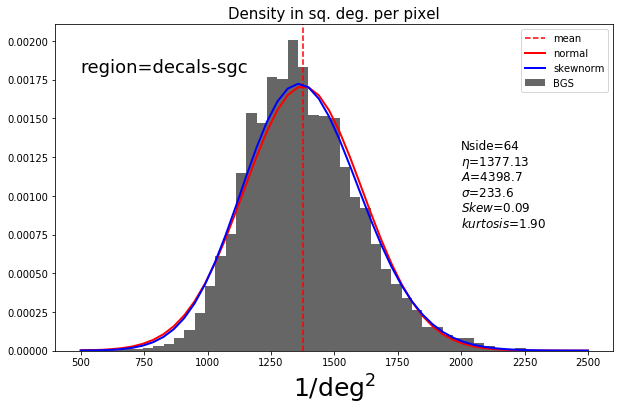

In [60]:
#
hppix = compute_statistics(nside=64,region='decals-sgc')

total density: 	 1405.32387
median density: 	 1407.13564
tot area (in sq.deg): 	 5437.78
pixel area (in sq.deg): 	 0.84
N of pixels: 	 6479
--------------
Variance: 	 88098.58
Standard Deviation: 	 296.81
Skewness: 	 -1.24
kurtosis: 	 5.85


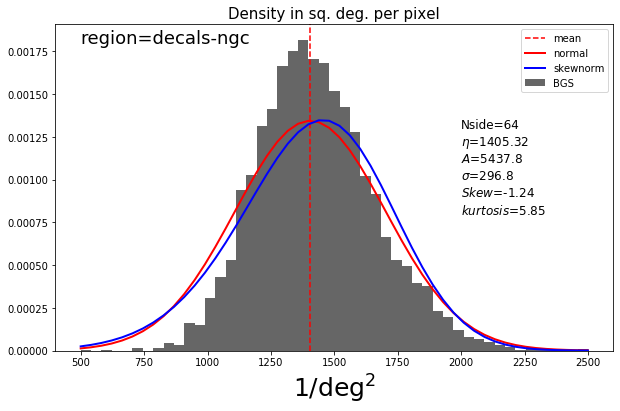

In [61]:
#
hppix = compute_statistics(nside=64,region='decals-ngc')

total density: 	 1320.35251
median density: 	 1322.54069
tot area (in sq.deg): 	 4636.26
pixel area (in sq.deg): 	 0.84
N of pixels: 	 5524
--------------
Variance: 	 70546.35
Standard Deviation: 	 265.61
Skewness: 	 -1.06
kurtosis: 	 4.45


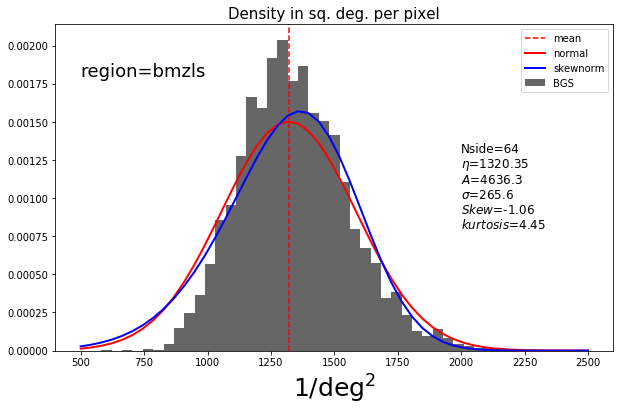

In [62]:
#
hppix = compute_statistics(nside=64,region='bmzls')

In [73]:
#

def pix2radec(pix, nside):
    """
    Converts healpix pixel number to RA ande dec (in degrees)
    """
    
    theta,phi  = hp.pix2ang(nside, pix,nest=True)
    ra, dec = 180./np.pi*phi,90.-180./np.pi*theta
    
    return ra, dec

def plot_pixels(nside):
    """
    Make plot of healpix pixels in DESI
    """
    # get pixel numbers inside desi
    surv_dict = {'bmzls':['BASS/MzLS', 'skyblue'], 
                 'decals-ngc':['DECaLS-NGC', 'navy'], 
                 'decals-sgc':['DECaLS-SGC', 'firebrick']}
    
    for key, val in surv_dict.items():
        ra, dec = read_desi(key)
        pix = hp.ang2pix(nside,(90.-np.array(dec))*(np.pi/180.),np.array(ra)*(np.pi/180.),nest=True)
        ra, dec = pix2radec(pix=np.unique(pix), nside=nside)
        plt.scatter(ra, dec, s=5, edgecolor="none",color=val[1],label=val[0])

    plt.xlabel("RA (deg)")
    plt.ylabel("Dec (deg)")
    plt.xlim(360, 0)
    plt.ylim(-30,90)
    plt.legend(bbox_to_anchor=(0., 1., 1., 0.), fontsize=15, frameon=False, scatterpoints=1,ncol=1, loc=0) 
    plt.show()


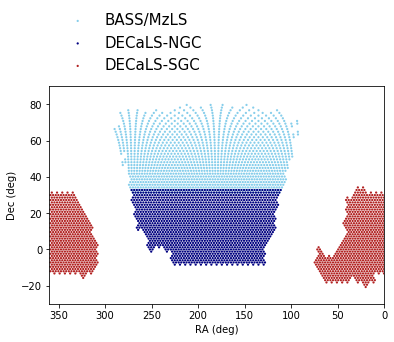

In [74]:
plot_pixels(nside=32)